In [2]:
import torch
import os
import numpy as np
from torch.utils.data import DataLoader
import text_anomalies as ta

# Recostruction loss analysis

Using the pretrained model, we can now analyze the reconstruction loss of the model. Using the reconstruction loss we might be able to detect anomalies by using a threshold.

In [3]:
# Load data
data = ta.DOECDataModule(data_dir="../data/doec/")
data.prepare_data()
data.setup()
dataset = data.dataset
dataloader = DataLoader(
    dataset=dataset,
    batch_size=32,
    num_workers=os.cpu_count(),
    shuffle=False,
    collate_fn=dataset.collate_fn,
)

In [4]:
# Load model
model = ta.model.SSVAE.load_from_checkpoint("../data/doec/models/ssvae_4.ckpt",
        vocab_size=30_000,
        label_size=data.num_classes,
        latent_size=65,
        hidden_size=512,
        embedding_size=300,
        rnn_num_layers=5,
        )
model.eval()
model.to("cuda")

SSVAE(
  (embedding): Embedding(30000, 300)
  (input_highway): Sequential(
    (0): Linear(in_features=300, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=240, bias=True)
    (3): ReLU()
    (4): Linear(in_features=240, out_features=180, bias=True)
    (5): ReLU()
    (6): Linear(in_features=180, out_features=150, bias=True)
    (7): ReLU()
  )
  (encoder): Encoder(
    (rnn): LSTM(150, 512, num_layers=5, batch_first=True, dropout=0.25, bidirectional=True)
  )
  (decoder): Decoder(
    (latent_to_hidden): Linear(in_features=65, out_features=5120, bias=True)
    (latent_to_state): Linear(in_features=65, out_features=5120, bias=True)
    (rnn): LSTM(300, 512, num_layers=5, batch_first=True, dropout=0.25, bidirectional=True)
    (output): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=30000, bias=True)
    )
  )
  (y_predict): Sequential(
    (0): Lin

Compute the reconstruction loss for all samples in the dataset.

In [5]:
import torch.nn as nn
from tqdm.auto import tqdm
# Get reconstruction loss
losses = []
for batch in tqdm(dataloader):
    x = batch["x"].to("cuda")
    y = batch["y_true"].to("cuda")

    # Forward pass
    x_hat, y_hat, alpha = model(x)

    # Calculate reconstruction loss for each sample in batch
    x_hat = x_hat.permute(0, 2, 1)  # (batch_size, vocab_size, seq_len)
    reconloss = nn.functional.nll_loss(
        input=x_hat, target=x, reduction="none"
    )  # (batch_size, seq_len)


    losses.append(reconloss.mean(dim=1).detach().cpu().numpy())

losses = np.concatenate(losses, axis=0)

  0%|          | 0/5383 [00:02<?, ?it/s]

We define a threshold at 95% of the reconstruction loss distribution. We plot the reconstruction loss distribution and the threshold. This will be used to detect anomalies.

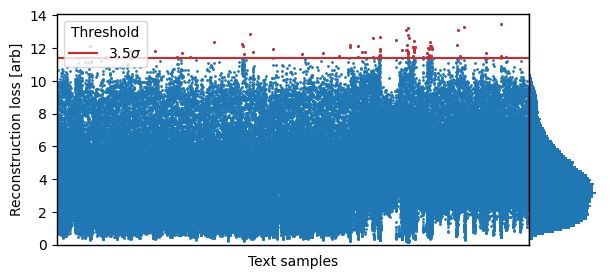

In [7]:
import matplotlib.pyplot as plt

# Set mpl spines thickness
plt.rcParams["axes.linewidth"] = 1


fig, axes = plt.subplots(1,2,figsize=(7,3),gridspec_kw={"width_ratios": [1, 0.15], "wspace": 0.0})


sigmas = np.quantile(losses, [0.68, 0.95, 0.997, 0.9995])

# x-axis: samples
# y-axis: reconstruction loss
ax = axes[0]
ax.scatter(np.arange(len(losses)), losses, s=1, color="tab:blue")

# Draw sigmas
ax.axhline(sigmas[3], color="tab:red", linestyle="-", label="$3.5\sigma$", alpha=1)


# Color samples above sigma
anomalies = np.where(losses > sigmas[3])

ax.scatter(anomalies, losses[anomalies], s=1, color="tab:red", alpha=1)

ax.set_xlim(0, len(losses))
ax.set_ylim(0)
# Logscale
ax.set_xlabel("Text samples")
ax.set_xticks([])
ax.set_ylabel("Reconstruction loss [arb]")

# Legend title
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="Threshold")


# KDE plot of reconstruction loss
ax = axes[1]
ax.hist(losses, bins=100, orientation="horizontal", color="tab:blue", density=True)

# Remove ticks and labels
ax.set_yticks([])
ax.set_xticks([])
#Shared ylim
ax.set_ylim(axes[0].get_ylim())

# Remove spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)


In [9]:
# Save figure
save_kwargs = {
    "bbox_inches": "tight",
    "pad_inches": 0,
    "dpi": 300,
    "transparent": True,
}
fig.savefig("./figures/reconstruction_analysis.pdf", **save_kwargs)
fig.savefig("./figures/reconstruction_analysis.png", **save_kwargs)

In [25]:
# Table of outliers
from text_anomalies.doec.preprocess import mapping


# Sort by reconstruction loss
outliers_ids = anomalies

# Get anomaly labels
df_outliers = dataset.data.iloc[outliers_ids]
df_outliers = df_outliers[["n", "title", "text", "file", "idno"]]
df_outliers.rename(columns={"idno": "id"}, inplace=True)
df_outliers["loss"] = losses[outliers_ids]

type_mapping = {
    "A": "Poetry",
    "B": "Prose",
    "C": "Interlinear Glosses",
    "D": "Glossaries",
    "E": "Runic Inscriptions",
    "F": "Inscriptions in the Latin Alphabet",
}

#Reorder columns
df_outliers = df_outliers[["loss", "id", "n", "title", "text", ]]

# Remove more than 256 characters from text
df_outliers["text"] = df_outliers["text"].apply(lambda x: x[:256] + "..." if len(x) > 256 else x)
# Replace all mappings
for key, value in mapping.items():
    df_outliers["title"] = df_outliers["title"].str.replace(key, value)


# Loss to two decimals
df_outliers["loss"] = df_outliers["loss"].apply(lambda x: f"{x:.2f}")
df_outliers.sort_values(by="loss", ascending=False, inplace=True)
df_outliers.drop(columns=["text"], inplace=True)
df_outliers.to_csv("../data/doec/reconstruction_outliers.csv", index=False)


In [21]:
for sigm in sigmas:
    print(sigm)
    print(sum(losses > sigm))
    print(sum(losses > sigm) / len(losses) * 100)
    print()

4.57673101425171
55119
32.00034834102586

8.088365554809569
8613
5.000435426282331

10.45529529571534
517
0.30015385061975675

11.409418823242182
87
0.05050944875032657



In [140]:
len(df_outliers)

87

In [141]:
87/len(dataset.data)*100
# To permile
87/len(dataset.data)*1000

0.5050944875032657

In [26]:
#to latex without index
df_25 = df_outliers.iloc[:25]
df_25.to_latex("./outliers.tex", index=False)

/tmp/ipykernel_858790/3031658069.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_25.to_latex("./outliers.tex", index=False)


In [165]:
dataset

,loss,id,n,title,text
154532,32.60,C31.7.3,102,AldV 7.3 (Meritt),quanto swa.
62404,32.21,B25.1.4,6,MsRune 1.4 (Derolez),c cen.
62417,31.84,B25.1.4,19,MsRune 1.4 (Derolez),e eoh.
62431,31.82,B25.1.4,33,MsRune 1.4 (Derolez),st stan.
62408,31.78,B25.1.4,10,MsRune 1.4 (Derolez),n ned.
130807,31.71,C31.7.1,104,AldV 7.1 (Nap),qui þa.
154611,31.66,C31.7.3,181,AldV 7.3 (Meritt),qui þa.
62400,31.50,B25.1.4,2,MsRune 1.4 (Derolez),u ur.
62426,31.43,B25.1.4,28,MsRune 1.4 (Derolez),y yr.
62405,31.16,B25.1.4,7,MsRune 1.4 (Derolez),g gyfu.


In [166]:
data.num_classes

2784

In [172]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 118.167MB
